In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/34 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N20.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N1.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/49 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N15.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/No18.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/31 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 6.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/3 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 5.jpeg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 1.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/26 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N26.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N5.jpg
/kaggle/input/brain-mri-images-for-b

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models 
from torchvision import models

In [3]:
data_dir='/kaggle/input/brain-mri-images-for-brain-tumor-detection'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/brain_tumor_dataset")
print(classes)

['no', 'yes', 'brain_tumor_dataset']
['no', 'yes']


In [4]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(100),             # resize shortest side to 100 pixels
        transforms.CenterCrop(100),         # crop longest side to 100 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [5]:
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 506


In [6]:
img, label = dataset[100]
print(img.shape)

torch.Size([3, 100, 100])


In [7]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [8]:
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  brain_tumor_dataset (0)


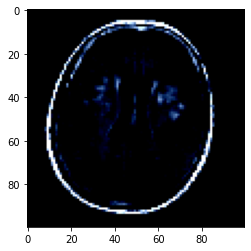

In [9]:
show_image(*dataset[20])

Label:  brain_tumor_dataset (0)


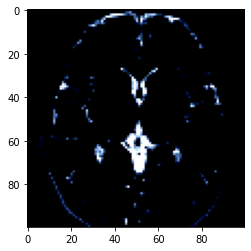

In [10]:
show_image(*dataset[60])

Label:  brain_tumor_dataset (0)


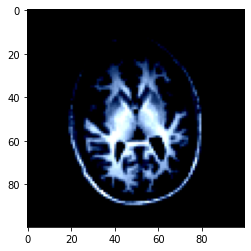

In [11]:
show_image(*dataset[65])

In [12]:
torch.manual_seed(20)
val_size = len(dataset)//10
test_size = len(dataset)//5
train_size = len(dataset) - val_size -test_size

In [13]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)   

(355, 50, 101)

In [14]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

In [15]:
def show(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(18,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

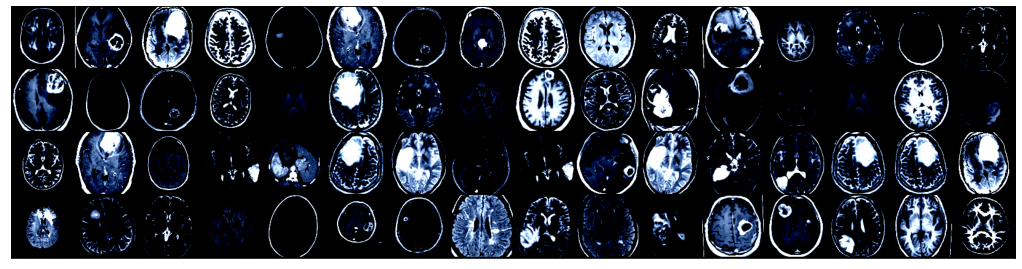

In [16]:
show(train_dl)

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [19]:
device=get_default_device()
device

device(type='cuda')

In [20]:
train_dl=DeviceDataLoader(train_dl,device)
val_dl=DeviceDataLoader(val_dl,device)

In [21]:
input_size = 128
output_size = 3

In [22]:
from sklearn.metrics import f1_score
import torch.nn.functional as F

In [23]:

  class model(ImageClassificationBase):
        def __init__(self):
            super().__init__()
            # Use a pretrained model
            self.network = models.resnet18(pretrained=True)
            # Replace last layer
            num_ftrs = self.network.fc.in_features
            self.network.fc = nn.Linear(num_ftrs,3)
        def forward(self, xb):
            return torch.sigmoid(self.network(xb))
        def freeze(self):
            # To freeze the residual layers
            for param in self.network.parameters():
                param.require_grad = False
            for param in self.network.fc.parameters():
                param.require_grad = True
        def unfreeze(self):
            # Unfreeze all layers
            for param in self.network.parameters():
                param.require_grad = True

In [24]:
model = to_device(model(), device)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [26]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.0562206506729126, 'val_acc': 0.46000000834465027}]

In [27]:
num_epochs = 10

lr = 0.001



In [28]:
history+= fit(num_epochs,lr,model,train_dl,val_dl,
              opt_func = torch.optim.Adam)

Epoch [0], train_loss: 1.0515, val_loss: 1.0514, val_acc: 0.4600
Epoch [1], train_loss: 0.9504, val_loss: 1.0135, val_acc: 0.4000
Epoch [2], train_loss: 0.9016, val_loss: 1.0753, val_acc: 0.2600
Epoch [3], train_loss: 0.8966, val_loss: 0.9962, val_acc: 0.4000
Epoch [4], train_loss: 0.8939, val_loss: 1.0552, val_acc: 0.3200
Epoch [5], train_loss: 0.8782, val_loss: 1.0627, val_acc: 0.3200
Epoch [6], train_loss: 0.8673, val_loss: 1.0364, val_acc: 0.3200
Epoch [7], train_loss: 0.8609, val_loss: 1.0543, val_acc: 0.3400
Epoch [8], train_loss: 0.8598, val_loss: 1.0392, val_acc: 0.2600
Epoch [9], train_loss: 0.8499, val_loss: 1.0567, val_acc: 0.2400


In [29]:
num_epochs = 15

lr = 0.0001

In [30]:
history+= fit(num_epochs,lr,model,train_dl,val_dl,
              opt_func = torch.optim.Adam)

Epoch [0], train_loss: 0.8524, val_loss: 1.0687, val_acc: 0.3800
Epoch [1], train_loss: 0.8465, val_loss: 1.0393, val_acc: 0.2800
Epoch [2], train_loss: 0.8424, val_loss: 1.0460, val_acc: 0.3400
Epoch [3], train_loss: 0.8483, val_loss: 1.0642, val_acc: 0.2600
Epoch [4], train_loss: 0.8428, val_loss: 1.0801, val_acc: 0.3000
Epoch [5], train_loss: 0.8430, val_loss: 1.0847, val_acc: 0.2600
Epoch [6], train_loss: 0.8310, val_loss: 1.0984, val_acc: 0.2200
Epoch [7], train_loss: 0.8403, val_loss: 1.1180, val_acc: 0.2200
Epoch [8], train_loss: 0.8320, val_loss: 1.1039, val_acc: 0.2800
Epoch [9], train_loss: 0.8284, val_loss: 1.1125, val_acc: 0.2600
Epoch [10], train_loss: 0.8282, val_loss: 1.1074, val_acc: 0.2800
Epoch [11], train_loss: 0.8254, val_loss: 1.1101, val_acc: 0.1800
Epoch [12], train_loss: 0.8268, val_loss: 1.1174, val_acc: 0.2800
Epoch [13], train_loss: 0.8268, val_loss: 1.1095, val_acc: 0.2600
Epoch [14], train_loss: 0.8251, val_loss: 1.1069, val_acc: 0.2800


In [31]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                   # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [32]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 150, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 150 x 16 x 16

            nn.Conv2d(150, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(200, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
             nn.MaxPool2d(2, 2), # output: 200 x 8 x 8

            nn.Conv2d(200, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(250, 250, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 250 x 4 x 4

            nn.Flatten(), 
            nn.Linear(36000, 3600),
            nn.ReLU(),
            nn.Linear(3600, 600),
            nn.ReLU(),
            nn.Linear(600, 30),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(30, 3))
    def forward(self, xb):
        return self.network(xb)

In [33]:
md=to_device(CnnModel(),device)
md

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(150, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(200, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(250, 250, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=36000, out_features=3600, bias=True)
    (17): ReLU()
    (18): Linear(in_featur

In [34]:
history = [evaluate(md, val_dl)]
history

[{'val_loss': 1.1027895212173462, 'val_acc': 0.2199999988079071}]

In [35]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: brain_tumor_dataset , Predicted: yes


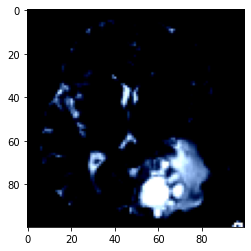

In [36]:
img, label = val_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: yes , Predicted: yes


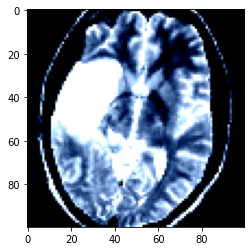

In [37]:
img, label = val_ds[3]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:',dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: brain_tumor_dataset , Predicted: brain_tumor_dataset


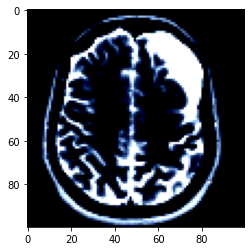

In [38]:
img, label = val_ds[5]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:',dataset.classes[label], ', Predicted:', predict_image(img, model))